<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/lab/lab9/Laborator_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rețele neurale pentru clasificare imaginilor

_Tudor Berariu, 2018_ (tudor.berariu@gmail.com)


În cadrul acestui laborator veți implementa o rețea neurală cu arhitectură convoluțională pentru clasificarea imaginilor.

Rețeaua va fi compusă din straturi convoluționale, straturi de Pooling pentru reducerea dimensionalității și activări de tip ReLU.
Rețeaua va avea straturi lineare la final și un strat softmax înainte de ieșiri. 

Funcția de cost folosită este negative log likelihood. Pentru optimizarea acesteia se va folosi SGD (stochastic gradient descent).

## 0. Resurse teoretice

* Citiți de aici despre straturile convoluțional și max pooling:
http://cs231n.github.io/convolutional-networks/#conv

* Citiți de aici despre cum se implementează eficient pașii de convoluție folosind funcția im2col din numpy:
https://wiseodd.github.io/techblog/2016/07/16/convnet-conv-layer/


## 1. Setul de date MNIST

Setul de date MNIST este compus din imagini de 28x28 pixeli reprezentând una dintre cele zece cifre 0-9.

Decomentați mai jos comanda `!pip install mnist` pentru a instala pachetul `mnist`.

In [1]:
!pip install mnist

import mnist
train_imgs = mnist.train_images()
train_labels = mnist.train_labels()
test_imgs = mnist.test_images()
test_labels  = mnist.test_labels()

### Exemple din setul de date MNIST

In [2]:
from typing import List
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Labels: [7 1 3 7 8 9 1 7 5 3 6 7 6 6 1]


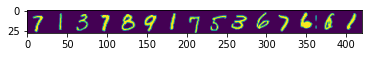

In [3]:
idxs = np.random.randint(0, len(train_imgs), 15)
imgs = np.concatenate(tuple(train_imgs[idx,:,:] for idx in idxs), axis=1)
plt.imshow(imgs)
print("Labels:", train_labels[idxs])

### Standardizarea datelor

Datele de intrare (imaginile) vor fi rescalate pentru a avea media zero și deviația standard 1.

In [4]:
mean, std  = train_imgs.mean(), train_imgs.std()
train_imgs = (train_imgs - mean) / std
test_imgs = (test_imgs - mean) / std

## 2. Construirea unei rețele de tip feed-forward

### Notații
  - dimensiunea datelor de intrare este $D = 28 * 28 = 784$, iar dimensiunea ieșirilor rețelei este $K=10$ (numărul de clase)
  - rețeaua neurală va avea $L$ straturi
  - $B$ va reprezenta dimensiunea batch-ului (numărul de exemple trecute în același timp prin rețea)
  - Vom nota cu ${\bf X} \in {\mathbb R}^{B \times D}$ un batch de intrări $\left\lbrace {\bf x}_0, {\bf x}_1, \dots {\bf x}_B \right\rbrace$ și similar ${\bf Y} \in {\mathbb R}^{B \times K}$
  - ${\bf x}^{(l)}$ reprezintă intrările stratului $l$ (${\bf x}^{(0)}$ va fi o imagine precum cele din setul MNIST de dimensiune $D$)
  - ${\bf y}^{(l)}$ reprezintă ieșirile stratului $l$ (${\bf y}^{(L-1)}$ reprezintă ieșirile rețelei)
  - ${\bf \theta}^{(l)}$ reprezintă parametrii stratului $l$
  - ${\cal L}$ reprezintă funcția de cost ( _negative log likelihood_ )
  

### Straturile rețelei

Unele straturi au parametri ce trebuie optimizați în timpul antrenării. Vom nota parametrii stratului $l$ cu $\bf{\theta}^{(l)}$.
Fiecare strat pe care îl veți implementa va avea trei metode:
 - `forward` calculează și întoarce ${\bf y}^{(l)} = f_l\left({\bf x}^{(l)}, {\bf \theta}^{(l)}\right)$
 - `backward` primește $\frac{\partial {\cal L}}{\partial {\bf y}^{(l)}}$, reține intern $\frac{\partial {\cal L}}{\partial {\bf \theta}^{(l)}}$ și întoarce $\frac{\partial {\cal L}}{\partial {\bf x}^{(l)}}$
 - `update` modifică parametrii locali ${\bf \theta}^{(l)}$ folosing gradientul stocat $\frac{\partial{\cal L}}{\partial{\bf \theta}^{(l)}}$

In [5]:
class Layer:

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass  # If a layer has no parameters, then this function does nothing

### Rețeaua neurală

  * în faza `forward` ieșirile stratului $l$ devin intrările stratului $l+1$: ${\bf x}^{(l+1)} = {\bf y}^{(l)}$
  * în faza `backward` gradientul în raport cu intrările stratului $l+1$ devine gradientul în raport cu ieșirile stratului $l$: $\frac{\partial {\cal L}}{\partial {\bf y}^{(l)}}=\frac{\partial {\cal L}}{\partial {\bf x}^{(l+1)}}$
  
Completați metoda `backward` din clasa `FeedForwardNetwork`.

In [6]:
class FeedForwardNetwork:
    
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy:np.ndarray) -> np.ndarray:
        # TODO <0> : Compute the backward phase
        dx = dy
        for i in reversed(range(len(self.layers))):
            dx = self.layers[i].backward(self._inputs[i], dx)

        del self._inputs
        return dx
    
    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

### Stratul linear

Un strat linear cu $M$ intrări și $N$ ieșiri are parametrii $\theta = \left( {\bf W}, {\bf b} \right)$ unde ${\bf W} \in \mathbb{R}^{M \times N}$ și ${\bf b} \in \mathbb{R}^{N}$.

Pentru un singur exemlu ${\bf x} \in {\mathbb R}^{M}$:
$$ {\bf y} = {\bf x}^{\intercal}{\bf W} + {\bf b} $$

Implementați metoda `forward` care primește un batch de exemple $X \in {\mathbb R}^{B\times M}$ și întoarce ieșirile corespunzătoare: $Y \in {\mathbb R}^{B\times N}$.

Implementați metoda `backward` care primește un batch de exemple $X \in {\mathbb R}^{B\times M}$ și gradientul în raport cu ieșirile $\frac{\partial {\cal L}}{\partial {\bf Y}}$ și realizează două lucruri:
  - calculează și salvează intern gradientul $\frac{\partial {\cal L}}{\partial {\bf \theta}}$
  - calculează și întoarce gradientul $\frac{\partial {\cal L}}{\partial {\bf X}}$
  
Implementați strategia de optimizare SGD cu _momentum_ (în metoda `update`).

In [7]:
class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)

        self.wv = 0
        self.bv = 0

    def forward(self, x: np.ndarray) -> np.ndarray:
        # compute the output of a linear layer
        return x @ self.weight + self.bias
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # compute dweight, dbias and  return dx
        self.dweight = x.T @ dy
        self.dbias = np.sum(dy, axis=0)

        return dy @ self.weight.T
    
    def update(self, mode='SGD', lr=0.001, mu=0.9):
        if mode == 'SGD':
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias
        elif mode == 'momentum':
            # implement momentum update
            self.wv = mu * self.wv + lr * self.dweight
            self.weight -= self.wv

            self.bv = mu * self.bv + lr * self.dbias
            self.bias -= self.bv
        else:
            raise ValueError('mode should be SGD or momentum, not ' + str(mode))

### The Rectified Linear Unit

Stratul ReLU aplică următoare următoare transformare neliniară element cu element:
$$y = \max\left(x, 0\right)$$

Implementați metodele `forward` și `backward` pentru un strat de activare ReLU.

In [8]:
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        # TODO <3> : Compute the output of a rectified linear unit
        return np.maximum(x, 0)
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        # TODO <4> : Compute the gradient w.r.t. x
        return dy * (x > 0)

### The Convolutional Layer

**[Cerințele 9.1 - 9.2] (4p)** Implementați metodele `forward` și `backward` pentru un strat convolutional.

#### Im2Col auxiliries from [CS231n assignment](https://github.com/huyouare/CS231n/blob/master/assignment2/cs231n/im2col.py)

In [9]:
def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
  # First figure out what the size of the output should be
  N, C, H, W = x_shape
  assert (H + 2 * padding - field_height) % stride == 0
  assert (W + 2 * padding - field_height) % stride == 0
  out_height = (H + 2 * padding - field_height) // stride + 1
  out_width = (W + 2 * padding - field_width) // stride + 1

  i0 = np.repeat(np.arange(field_height), field_width)
  i0 = np.tile(i0, C)
  i1 = stride * np.repeat(np.arange(out_height), out_width)
  j0 = np.tile(np.arange(field_width), field_height * C)
  j1 = stride * np.tile(np.arange(out_width), out_height)
  i = i0.reshape(-1, 1) + i1.reshape(1, -1)
  j = j0.reshape(-1, 1) + j1.reshape(1, -1)

  k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

  return (k, i, j)


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
  """ An implementation of im2col based on some fancy indexing """
  # Zero-pad the input
  p = padding
  x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

  k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding,
                               stride)

  cols = x_padded[:, k, i, j]
  C = x.shape[1]
  cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
  return cols


def col2im_indices(cols, x_shape, field_height=3, field_width=3, padding=1,
                   stride=1):
  """ An implementation of col2im based on fancy indexing and np.add.at """
  N, C, H, W = x_shape
  H_padded, W_padded = H + 2 * padding, W + 2 * padding
  x_padded = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
  k, i, j = get_im2col_indices(x_shape, field_height, field_width, padding,
                               stride)
  cols_reshaped = cols.reshape(C * field_height * field_width, -1, N)
  cols_reshaped = cols_reshaped.transpose(2, 0, 1)
  np.add.at(x_padded, (slice(None), k, i, j), cols_reshaped)
  if padding == 0:
    return x_padded
  return x_padded[:, :, padding:-padding, padding:-padding]

#### Convolutional Layer implementation

In [10]:
class ConvolutionalLayer(Layer):
    def __init__(self, inputs_depth: int, inputs_height: int, inputs_width: int, outputs_depth: int, k: int, stride: int):
        # Number of inputs, number of outputs, filter size, stride

        self.inputs_depth = inputs_depth
        self.inputs_height = inputs_height
        self.inputs_width = inputs_width

        self.k = k
        self.stride = stride

        self.outputs_depth = outputs_depth
        self.outputs_height = int((self.inputs_height - self.k) / self.stride + 1)
        self.outputs_width = int((self.inputs_width - self.k) / self.stride + 1)

        # Layer's parameters
        self.weights = np.random.normal(
            0,
            np.sqrt(2.0 / float(self.outputs_depth + self.inputs_depth + self.k + self.k)),
            (self.outputs_depth, self.inputs_depth, self.k, self.k)
        )
        self.biases = np.random.normal(
            0,
            np.sqrt(2.0 / float(self.outputs_depth + 1)),
            (self.outputs_depth, 1)
        )

        # Gradients
        self.g_weights = np.zeros(self.weights.shape)
        self.g_biases = np.zeros(self.biases.shape)

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        batch_size, dd, hh, ww = inputs.shape
        assert (dd, hh, ww == self.inputs_depth, self.inputs_height, self.inputs_width)

        # Computed values
        outputs = np.zeros((batch_size, self.outputs_depth, self.outputs_height, self.outputs_width))

        # TODO (9.1)
        # -> compute outputs
        inputs_col = im2col_indices(inputs, self.weights.shape[2], self.weights.shape[3], 0, self.stride)
        w_col = self.weights.reshape((self.weights.shape[0], -1))
        b_col = self.biases.reshape(-1, 1)
        outputs = w_col @ inputs_col + b_col

        outputs = outputs.reshape(self.outputs_depth, self.outputs_height, self.outputs_width, batch_size)

        outputs = outputs.transpose(3, 0, 1, 2)

        return outputs


    def backward(self, inputs: np.ndarray, output_errors: np.ndarray) -> np.ndarray:
        batch_size, dd, hh, ww = inputs.shape
        assert (output_errors.shape == batch_size, self.outputs_depth, self.outputs_height, self.outputs_width)

        # TODO (9.2.i)
        # Compute the gradients w.r.t. the bias terms (self.g_biases)
        self.g_biases = np.sum(output_errors, axis=(0, 2, 3)).reshape((self.weights.shape[0], -1))
        
        # TODO (9.2.ii)
        # Compute the gradients w.r.t. the weights (self.g_weights)
        inputs_col = im2col_indices(inputs, self.weights.shape[2], self.weights.shape[3], 0, self.stride)
        dout_reshaped = output_errors.transpose(1, 2, 3, 0).reshape(self.weights.shape[0], -1)
        self.g_weights = (dout_reshaped @ inputs_col.T).reshape(self.weights.shape)

        # TODO (9.2.iii)
        # Compute and return the gradients w.r.t the inputs of this layer
        # return these gradients
        dx_cols = self.weights.reshape(self.weights.shape[0], -1).T @ dout_reshaped
        dx = col2im_indices(dx_cols, inputs.shape, self.k, self.k, 0, self.stride)

        return dx


    def update_parameters(self, mode='SGD', lr=0.001, mu=0.9):
        if mode == 'SGD':
            self.weights -= lr * self.g_weights
            self.biases -= lr * self.g_biases
        elif mode == 'momentum':
            # implement/reuse momentum update from Lab 8
            self.wv = mu * self.wv + lr * self.dweight
            self.weight -= self.wv

            self.bv = mu * self.bv + lr * self.dbias
            self.bias -= self.bv
        else:
            raise ValueError('mode should be SGD or momentum, not ' + str(mode))

    def to_string(self):
        return "[C ((%s, %s, %s) -> (%s, %s ) -> (%s, %s, %s)]" % (
            self.inputs_depth, self.inputs_height, self.inputs_width, self.k, self.stride, self.outputs_depth,
            self.outputs_height, self.outputs_width)


<>:34: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:55: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:34: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:55: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-10-4bd462edcaa4>:34: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (dd, hh, ww == self.inputs_depth, self.inputs_height, self.inputs_width)
<ipython-input-10-4bd462edcaa4>:55: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (output_errors.shape == batch_size, self.outputs_depth, self.outputs_height, self.outputs_width)


### The Max Pooling Layer

**[Cerința 9.3] (2p)** Implementați metodele `forward` și `backward` pentru un strat de tip Max Pooling.

In [11]:
class MaxPoolingLayer(Layer):

    def __init__(self, size: int = 2, stride: int = 2):
        # Dimensions: stride
        self.size = size
        self.stride = stride

        # indexes of max activations
        self.switches = {}


    def forward(self, inputs):
        batch_size, dd, hh, ww = inputs.shape

        h_out = (hh - self.size) // self.stride + 1
        w_out = (ww - self.size) // self.stride + 1

        in_col = im2col_indices(
            inputs.reshape(batch_size * dd, 1, hh, ww),
            self.size, self.size, 0, self.stride)

        self.switches = np.argmax(in_col, 0)

        return in_col[self.switches, range(self.switches.size)]\
            .reshape(h_out, w_out, batch_size, dd)\
            .transpose(2, 3, 0, 1)


    def backward(self, inputs, output_errors):
        batch_size, dd, hh, ww = inputs.shape

        in_col = im2col_indices(
            inputs.reshape(batch_size * dd, 1, hh, ww),
            self.size, self.size, 0, self.stride)
        din_col = np.zeros_like(in_col)

        dout = output_errors.transpose(2, 3, 0, 1).ravel()
        din_col[self.switches, range(self.switches.size)] = dout

        return col2im_indices(
            din_col,
            (batch_size * dd, 1, hh, ww),
            self.size, self.size, 0, self.stride)\
                .reshape(inputs.shape)

    def to_string(self):
        return "[MP (%s x %s)]" % (self.size, self.stride)

### The Linearization Layer

**[Cerința 9.4] (2p)** Implementați metodele `forward` și `backward` pentru un strat de tip Linearization.

**Nota** Acesta este un strat care rearanjeaza datele dintr-un volum (numar canale x inaltime x latime) intr-un singur vector; (util la trecerea de la volume de imagini la straturi complet conectate)

In [12]:
class LinearizeLayer(Layer):

    def __init__(self, depth: int, height: int, width: int):
        # Dimensions: depth, height, width
        self.depth = depth
        self.height = height
        self.width = width


    def forward(self, inputs: np.ndarray) -> np.ndarray:
        # inputs are of shape (batch_size, depth, height, width)
        # outputs are of shape (batch_size, depth x height x width)
        
        # TODO 1
        # Reshape inputs- transform volume to column
        return inputs.reshape(inputs.shape[0], -1)


    def backward(self, inputs: np.ndarray, output_errors: np.ndarray) -> np.ndarray:
        # unused argument - inputs
        # output_errors of shape (batch_size, depth x height x width)

        # TODO 1
        # Reshape gradients - transform column to volume
        return output_errors.reshape(-1, self.depth, self.height, self.width)


    def to_string(self):
        return "[Lin ((%s, %s, %s) -> %s)]" % (self.depth, self.height, self.width, self.depth * self.height * self.width)

## 3. Funcția de cost

Funcția de cost pe care o vom folosi este _cross entropy_ care combină un _softmax_ și un cost _negative log-likelihood_. (Matematica la tablă)

Dacă ${\bf y}$ reprezintă ieșrile rețelei pentru o intrare ${\bf x}$, atunci ${\bf y}$ va avea o dimensiune egală cu numărul de clase $K$. Atunci probabilitatea (prezisă de rețea) ca exemplul ${\bf x}$ să aparțină clasei $k$ va fi $p_k$:

$$
\begin{align}
p_k &= \frac{e^{y_k}}{\sum_j e^{y_j}} & & \text{softmax} \\
{\cal L} &= -\log p_t & & \text{negative log-likelihood}
\end{align}
$$


Pentru un batch de dimensiune $B$ se va face media costurilor corespunzătare fiecărui exemplu ($p_k$ este o funcție de ${\bf x}$ și ${\bf \theta}$):

$$ {\cal L} = \frac{1}{B} \sum_{({\bf x}, {\bf t}) \in Batch} -\log p_t \left({\bf x}, \theta\right) $$

Implementați metodele `forward` și `backward` pentru un funcția de cost _cross-entropy_ (o vom privi ca pe un strat suplimentar).

In [13]:
class CrossEntropy:
    def __init__(self):
        pass

    def _softmax(self, y, t):
        e_t = np.exp([y[i][t[i]] for i in range(len(t))])
        return e_t / np.exp(y).sum(axis=1)

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        # TODO <5> : Compute the negative log likelihood
        return -np.mean(np.log(self._softmax(y, t)))
    
    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        # TODO <6> : Compute dl/dy
        diff = [[yj == y[i][t[i]] for yj in y[i]] for i in range(y.shape[0])]

        return [[(np.exp(y[i][j]) / np.sum(np.exp(y[i])) - diff[i][j]) / y.shape[0]\
            for j in range(len(y[i]))] for i in range(len(y))]

        return y

### Acuratețea

Calculați acuratețea predicțiilor ${\bf y}$ în raport cu clasele corecte ${\bf t}$ (rația exemplelor pentru care clasa corectă a avut probabilitatea prezisă maximă).

In [14]:
from sklearn.metrics import accuracy_score

def accuracy(y: np.ndarray, t: np.ndarray) -> float:
    return accuracy_score(t, np.argmax(y, axis=1))

## 4. Antrenarea rețelei neurale

### [Cerinta 9.5] (2p) - Crearea si antrenarea unei arhitecturi de retea convolutionala similara cu LeNet

Implementati [arhitectura LeNet](https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/) 
  - Conv(1, 28, 28, 20, 5, 1), Relu, MaxPool(2, 2), Conv(20, 12, 12, 50, 5, 1), Relu, MaxPool(2,2), Linearize(50, 4, 4), Linear(800, 500), Relu, Linear(500, 10), Softmax
  
**Adaptati codul de antrenare din laboratorul precedent pentru a antrena reteaua.**

**Comparati rezultatele obtinute cu cele ale retelei MLP antrenate data trecuta.**

In [15]:
# TODO 9.5: antrenare retea LeNet
BATCH_SIZE = 128
EPOCHS_NO = 20

optimize_args = {'mode': 'momentum', 'lr': .005}

net = FeedForwardNetwork([
    ConvolutionalLayer(1, 28, 28, 20, 5, 1),
    ReLU(),
    MaxPoolingLayer(2, 2),
    ConvolutionalLayer(20, 12, 12, 50, 5, 1),
    ReLU(),
    MaxPoolingLayer(2, 2),
    LinearizeLayer(50, 4, 4),
    Linear(800, 500),
    ReLU(),
    Linear(500, 10)
])
cost_function = CrossEntropy()

for epoch in range(EPOCHS_NO):
    for b_no, idx in enumerate(range(0, len(train_imgs), BATCH_SIZE)):
        # 1. Prepare next batch
        x = train_imgs[idx:idx + BATCH_SIZE,:,:]
        t = train_labels[idx:idx + BATCH_SIZE]
        x = np.expand_dims(x, axis=3)
        x = x.transpose(0, 3, 1, 2)
        
        # 2. Compute gradient
        y = net.forward(x, True)
        loss = cost_function.forward(y, t)
        dy = cost_function.backward(y, t)
        dx = net.backward(dy)
        
        # 3. Update network parameters
        net.update(**optimize_args)
        
        print(f'\rEpoch {epoch + 1:02d} '
              f'| Batch {b_no:03d} '
              f'| Train NLL: {loss:6.3f} '
              f'| Train Acc: {accuracy(y, t) * 100:6.2f}% ', end='')

    t = np.expand_dims(test_imgs, axis=3)
    y = net.forward(t.transpose(0, 3, 1, 2), train=False)
    test_nll = cost_function.forward(y, test_labels)
    print(f'| Test NLL: {test_nll:6.3f} '
          f'| Test Acc: {accuracy(y, test_labels) * 100:3.2f}%')

Epoch 01 | Batch 468 | Train NLL:  0.281 | Train Acc:  95.83% | Test NLL:  0.176 | Test Acc: 94.46%
Epoch 02 | Batch 468 | Train NLL:  0.180 | Train Acc:  98.96% | Test NLL:  0.116 | Test Acc: 96.44%
Epoch 03 | Batch 468 | Train NLL:  0.184 | Train Acc:  98.96% | Test NLL:  0.106 | Test Acc: 96.94%
Epoch 04 | Batch 468 | Train NLL:  0.183 | Train Acc:  98.96% | Test NLL:  0.123 | Test Acc: 96.30%
Epoch 05 | Batch 468 | Train NLL:  0.176 | Train Acc:  98.96% | Test NLL:  0.112 | Test Acc: 96.61%
Epoch 06 | Batch 468 | Train NLL:  0.198 | Train Acc:  98.96% | Test NLL:  0.110 | Test Acc: 96.66%
Epoch 07 | Batch 468 | Train NLL:  0.183 | Train Acc:  98.96% | Test NLL:  0.109 | Test Acc: 96.62%
Epoch 08 | Batch 468 | Train NLL:  0.166 | Train Acc:  98.96% | Test NLL:  0.114 | Test Acc: 96.45%
Epoch 09 | Batch 468 | Train NLL:  0.175 | Train Acc:  98.96% | Test NLL:  0.100 | Test Acc: 97.03%
Epoch 10 | Batch 468 | Train NLL:  0.160 | Train Acc:  98.96% | Test NLL:  0.084 | Test Acc: 97.45%


## Teste

Executați ```test0() and test16() and test7()``` pentru a rula testele.

In [16]:
from numpy.linalg import norm 

def close_enough(arr1, arr2, max_err = 0.0000001):
    assert(arr1.shape == arr2.shape)
    return norm(arr1.reshape(arr1.size) - arr2.reshape(arr2.size)) < max_err

def test0():
    fakex = [np.random.randn(128, n) for n in [20, 40, 30, 10]]

    class DummyLayer:
        def __init__(self, idx):
            self.idx = idx

        def forward(self, x):
            return fakex[self.idx + 1]

        def backward(self, x, dldy):
            if not np.allclose(x, fakex[self.idx]):
                raise Exception("Intrări greșite în backward")
            if not np.allclose(dldy, -fakex[self.idx+1]):
                raise Exception("Intrări greșite în backward")
            return -x

    try:
        net = FeedForwardNetwork([DummyLayer(i) for i in range(3)])
        net.forward(fakex[0])
        net.backward(-fakex[-1])
        print("Cerința 0 rezolvată corect!")
        return True
    except NotImplementedError as e:
        print("Cerința 0 nu a fost implementată!")
    except Exception as e:
        print(e)
        print("Cerința 0 are erori.")
        
    return False
        
def test16():
    __x = np.array([[-3.0731, -1.9081, -0.7283, -0.0757, -0.7577],
                    [ 2.4041, -1.1506, -0.5924,  1.3016,  1.0882],
                    [-0.5254,  0.3519, -0.9633, -2.7393, -0.9745]])
    __w = np.array([[ 1.3214, -0.5886, -0.0351,  1.2084,  1.2661, -0.9979, -0.1172],
                    [-0.4022,  0.1168,  0.9020, -2.0098, -0.5409, -0.3876, -0.1719],
                    [-1.1125, -0.5556,  0.8843,  0.6995,  0.4929,  0.7523,  0.1832],
                    [ 0.2267,  0.6757,  1.1286, -0.3218,  1.6934, -0.1782, -0.3467],
                    [-0.6062,  0.4426,  0.5090,  0.4772, -0.5721,  0.8658, -0.5999]])
    __b = np.array([ 0.3335,  0.5051, -0.1393,  1.2116,  1.7836, -0.6597,  0.3553])
    __y = np.array([[-1.70746622, 2.10919555, -2.8676804, 0.48630531, -1.1288499, 1.95609904, 1.39083457],
                    [4.26749994, 0.64592254, 0.23749513, 6.11524068, 6.73936681, -2.34822291, -0.94127596],
                    [0.5391161, -0.89159687, -4.24288533, -0.38789499, -3.62798139, -1.35206921, 1.71422657]])
    
    __dy = np.array([[ 1.5555, -0.8978, -0.2917, -0.3868, -0.8257, -0.3491, -0.8658],
                     [ 1.1146,  1.4914,  0.9591, -0.2613,  0.5887,  0.4794,  0.8565],
                     [-0.1552, -1.6319,  1.7642,  1.0503,  0.1035 , -0.7186, -0.9782]])
    __dx = np.array([[ 1.53113221,  0.51455541, -2.588423,   -1.49460989, -0.98384103],
                     [ 0.41215308,  0.46469672, -0.59552791,  3.04147235, -0.08763244],
                     [ 2.92549149, -0.25707023,  2.70531668,  1.15769427,  0.67643021]])
    __dw = np.array(
        [[-2.01905511,  7.20190418,  2.2752849,   0.00865613,  3.89837344,  2.60289719, 5.23374791],
         [-4.30512319, -0.57717827,  0.07387429,  1.40830543,  0.9345816,  -0.13835527, 0.3223155 ],
         [-1.64365553,  1.34237165, -2.05517959, -0.57525343,  0.15290988,  0.66248035, 1.0654716 ],
         [ 1.75815137,  6.47943337, -3.56222681, -3.18791411,  0.54523986,  2.61887489, 3.85994472],
         [ 0.18554777,  3.89349109, -0.45449919, -1.01478565,  1.16539548,  1.48647185, 2.54131586]]
    )
    __db = np.array([ 2.5149, -1.0383,  2.4316,  0.4022, -0.1335, -0.5883, -0.9875])
    
    __y_relu = np.array([[0, 2.10919555, 0, 0.48630531, 0, 1.95609904, 1.39083457],
                         [4.26749994, 0.64592254, 0.23749513, 6.11524068, 6.73936681, 0, 0],
                         [0.5391161, 0, 0, 0, 0, 0, 1.71422657]])
    __drelu = np.array([[0, -0.8978, 0, -0.3868, 0, -0.3491, -0.8658],
                        [ 1.1146,  1.4914,  0.9591, -0.2613,  0.5887,  0,  0],
                        [-0.1552, 0,  0,  0,  0 , 0, -0.9782]])
    
    __t = np.array([3, 1, 2])
    __dl_dy = np.array(
        [[ 2.80870645e-03,  1.27661957e-01,  8.80302096e-04, -3.08142112e-01,
           5.00952130e-03,  1.09539948e-01,  6.22416775e-02],
         [ 1.73238217e-02, -3.32870086e-01,  3.07917841e-04,  1.09927743e-01,
           2.05192672e-01,  2.31991342e-05,  9.47329526e-05],
         [ 6.60308812e-02,  1.57905168e-02, -3.32780047e-01,  2.61307149e-02,
           1.02329216e-03,  9.96358772e-03,  2.13841054e-01]]
    )


    try:
        lin = Linear(5, 7)
        lin.weight = __w.copy()
        lin.bias = __b.copy()
        y = lin.forward(__x.copy())
        if not np.allclose(y, __y):
            raise Exception("Ieșiri greșite")
        print("Cerința 1 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 1 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 1 are erori.")
        return False
        
    try:
        dx = lin.backward(__x.copy(), __dy.copy())
        if not np.allclose(dx, __dx):
            raise ValueError("dL/dx greșit")
        if not np.allclose(lin.dweight, __dw):
            raise ValueError("dL/dw greșit")
        if not np.allclose(lin.dbias, __db):
            raise ValueError("dL/db greșit")
        print("Cerința 2 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 2 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 2 are erori.")
        return False

    try:
        relu = ReLU()
        y_relu = relu.forward(__y.copy())
        if not np.allclose(y_relu, __y_relu):
            raise ValueError("ReLU(x) greșit")
        print("Cerința 3 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 3 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 3 are erori.")
        return False
            
    try:
        relu = ReLU()
        drelu = relu.backward(__y.copy(), __dy.copy())
        if not np.allclose(drelu, __drelu):
            raise ValueError("ReLU.backward greșit")
        print("Cerința 4 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 4 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 4 are erori.")
        return False
    
    try:
        ce = CrossEntropy()
        loss = ce.forward(__y.copy(), __t.copy())
        if np.abs(loss - 5.1874357237332545) > 1e-6:
            raise ValueError(f"Valoare greșită nll: {loss:f} în loc de 5.1874357237332545")
        print("Cerința 5 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 5 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 5 are erori.")
        return False
    
    try:
        ce = CrossEntropy()
        dl_dy = ce.backward(__y.copy(), __t.copy())
        if not np.allclose(dl_dy, __dl_dy) > 1e-6:
            raise ValueError(f"Valoare greșită pentru dNLL/dy")
        print("Cerința 6 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 6 nu a fost implementată!")
        return False
    except Exception as e:
        print(e)
        print("Cerința 6 are erori.")
        return False
    
    return True

def test7():  # Acuratețea
    y = np.array([[ 0.6460014 , -0.05876393, -1.36496105, -0.07057596,  0.54938383],
                  [-0.8033942 , -0.51753041,  0.92278036, -1.66303585, -0.36537512],
                  [-1.3710599 ,  0.65598193, -0.75527154,  1.21609284,  0.08284123],
                  [-1.24696857,  0.32676634,  0.09572539,  1.38316398, -0.14110726],
                  [-2.01698315,  2.06123375, -1.68003675,  0.0504592 ,  0.04427597],
                  [-0.8893451 ,  1.74695148, -0.29394473,  0.74203068, -0.75185261],
                  [ 1.34126333, -0.5272606 ,  1.46458319,  1.59529987,  1.86884676],
                  [-0.58987297,  1.10900165, -0.71208103,  0.20478154, -1.26693567],
                  [-2.17730677, -1.36147532, -1.49679182,  0.24812177, -0.13368035],
                  [-0.48730599,  1.31710647,  0.41765538,  1.19869192, -0.05301611],
                  [-0.10655224, -0.21174034,  1.31548647, -0.57990281,  0.85868472],
                  [-0.32055613, -2.17817118, -0.28488692,  1.62977524,  0.25150929],
                  [ 0.07704727,  1.67710047,  1.83368441, -0.45456845, -0.74474969]])
    t = np.array([0, 2, 3, 3, 1, 0, 1, 1, 2, 1, 2, 3, 2])
    try:
        acc = accuracy(y, t)
        if np.abs(acc - 0.7692307692307693) > 1e-7:
            raise ValueError(f"{acc:f} != 10/13")
        print(f"Cerința 7 rezolvată corect!")
    except NotImplementedError as e:
        print("Cerința 7 nu a fost implementată!")
    except Exception as e:
        print(e)
        print("Cerința 7 are erori.")

    return True


def test_convolutional_layer():

    np.random.seed(0)
    l = ConvolutionalLayer(2, 3, 4, 3, 2, 1)

    l.weights = np.random.rand(3, 2, 2, 2)

    l.biases = np.random.rand(3, 1)

    x = np.array([[[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]],
                  [[13, 14, 15, 16], [17, 18, 19, 20], [21, 22, 23, 24]]]])

    print("Testing forward computation...")
    output = l.forward(x)
    target = np.array([[[[ 34.55043437, 38.95942899, 43.36842361],
                        [ 52.18641284, 56.59540746, 61.00440208]],
    [[ 30.72457988, 34.08923073, 37.45388158],
     [ 44.18318328, 47.54783413, 50.91248498]],
     [[ 28.2244684, 31.30220961, 34.37995083],
      [ 40.53543326, 43.61317448, 46.69091569]]]])
    assert (output.shape == target.shape), "Wrong output size"
    assert close_enough(output, target), "Wrong values in layer ouput"
    print("Forward computation implemented ok!")

    output_err = np.random.rand(1, 3, 2, 3)

    print("Testing backward computation...")

    g = l.backward(x, output_err)
    # print(l.g_biases)
#    print(l.g_weights)
#    print(g)

    print("    i. testing gradients w.r.t. the bias terms...")
    gbias_target =  np.array([[ 2.4595299 ],
                              [ 3.86207926],
                              [ 1.17504241]])

    print(l.g_biases.shape)
    print(gbias_target.shape)

    assert (l.g_biases.shape == gbias_target.shape), "Wrong size"
    assert close_enough(l.g_biases, gbias_target), "Wrong values"
    print("     OK")

    print("   ii. testing gradients w.r.t. the weights...")
    gweights_target = np.array(
            [[[[ 12.19071134, 14.65024124],
               [ 22.02883093, 24.48836083]],
    [[ 41.70507011, 44.1646    ],
     [ 51.54318969, 54.00271959]]],

    [[[ 17.14269456, 21.00477382],
      [ 32.59101161, 36.45309087]],

  [[ 63.4876457 , 67.34972496],
   [ 78.93596275, 82.79804201]]],

 [[[  5.38434096,  6.55938337],
   [ 10.08451061, 11.25955302]],

  [[ 19.4848499 , 20.65989231],
   [ 24.18501955, 25.36006196]]]]
    )

    assert (l.g_weights.shape == gweights_target.shape), "Wrong size"
    assert close_enough(l.g_weights, gweights_target), "Wrong values"
    print("     OK")

    return True


def test_max_pooling_layer():

    l = MaxPoolingLayer(2)

    x = np.array([[[[1, 2, 3, 4], [5, 6, 7, 8]],
                  [[9, 10, 11, 12], [13, 14, 15, 16]],
                  [[17, 18, 19, 20], [21, 22, 23, 24]]]])

    print("Testing forward computation...")
    output = l.forward(x)
    target = np.array([[[[6, 8]],
                       [[14, 16]],
                       [[22, 24]]]])
    assert (output.shape == target.shape), "Wrong output size"
    assert close_enough(output, target), "Wrong values in layer ouput"
    print("Forward computation implemented ok!")


    output_err = output

    print("Testing backward computation...")

    g = l.backward(x, output_err)
    print(g)


    print("Testing gradients")
    in_target = np.array([[[[0, 0, 0, 0], [0, 6, 0, 8]],
                          [[0, 0, 0, 0], [0, 14, 0, 16]],
                          [[0, 0, 0, 0], [0, 22, 0, 24]]]])

    assert (g.shape == in_target.shape), "Wrong size"
    assert close_enough(g, in_target), "Wrong values in gradients"
    print("     OK")

    print("Backward computation implemented ok!")
    return True
    

def test_linearize_layer():

    l = LinearizeLayer(2, 3, 4)

    x = np.array([[[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]],
                  [[13, 14, 15, 16], [17, 18, 19, 20], [21, 22, 23, 24]]]])

    print("Testing forward computation...")
    output = l.forward(x)
    target = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24]])
    target = target.reshape(1, len(target))
    
    assert (output.shape == target.shape), "Wrong output size"
    assert close_enough(output, target), "Wrong values in layer ouput"
    print("Forward computation implemented ok!")

    output_err = output

    print("Testing backward computation...")

    g = l.backward(x, output_err)

    print("Testing gradients")
    in_target = x

    assert (g.shape == in_target.shape), "Wrong size"
    assert close_enough(g, in_target), "Wrong values in gradients"
    print("     OK")

    print("Backward computation implemented ok!")
    return True


In [17]:
test0() and test16() and test7()

Cerința 0 rezolvată corect!
Cerința 1 rezolvată corect!
Cerința 2 rezolvată corect!
Cerința 3 rezolvată corect!
Cerința 4 rezolvată corect!
Cerința 5 rezolvată corect!
Cerința 6 rezolvată corect!
Cerința 7 rezolvată corect!


True

In [18]:
test_convolutional_layer() and test_max_pooling_layer() and test_linearize_layer()

Testing forward computation...
Forward computation implemented ok!
Testing backward computation...
    i. testing gradients w.r.t. the bias terms...
(3, 1)
(3, 1)
     OK
   ii. testing gradients w.r.t. the weights...
     OK
Testing forward computation...
Forward computation implemented ok!
Testing backward computation...
[[[[ 0  0  0  0]
   [ 0  6  0  8]]

  [[ 0  0  0  0]
   [ 0 14  0 16]]

  [[ 0  0  0  0]
   [ 0 22  0 24]]]]
Testing gradients
     OK
Backward computation implemented ok!
Testing forward computation...
Forward computation implemented ok!
Testing backward computation...
Testing gradients
     OK
Backward computation implemented ok!


True

## Concluzii
Acuratetile retelei *LeNet* sunt:
- fara momentum: 97.84%
- cu momentum: 97.56%

Pentru comparatie, acuratetile retelei *MLP* din laboratorul trecut sunt:
- fara momentum: 95.61%
- cu momentum: 97.81%

Ceea ce se intampla, cel mai probabil, este ca setul de date este unul prea simplu pentru *LeNet*, drept care aceasta nu prea are ce sa mai invete dincolo de 98%. Se plafoneaza deja de pe la iteratia a 15-a, iar pana atunci, acuratetea de 97% se atinge din primele 10 epoci. Reteaua *MLP* e imbunatatita cu ~2% de adaugarea momentumului, dar si aceasta crestere este destul de mica. Cel mai probabil, diferentele reale dintre modele (*LeNet* ar trebui sa fie semnificativ mai bun) s-ar observa pe seturi de date si probleme mai complexe.